# \[KAN\] Other Examples

SEOYEON CHOI  
2024-07-13

ref: [1](https://ddangchani.github.io/KAN/)

# Import

In [2]:
import pandas as pd

import kan
import matplotlib.pyplot as plt
import numpy as np
import torch
from kan import KAN, create_dataset
from sklearn.datasets import make_classification, load_iris
from sklearn.model_selection import train_test_split

import torchvision
from fastai.vision.all import * 

# Data

In [38]:
iris = load_iris()

# KAN

## Symbolic regression

특정 함수로 표현 가능 $\rightarrow$ 아핀 변환으로 고정 $\rightarrow$
파라메터 수 줄이기 가능 $\rightarrow$ 재학습

In [207]:
f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)

In [208]:
torch.manual_seed(0)
X = torch.rand(1000, 2) * 2 - 1 # Random points in [-1, 1]^2
y = f(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
dataset = dict(train_input=X_train, train_label=y_train, test_input=X_test, test_label=y_test)

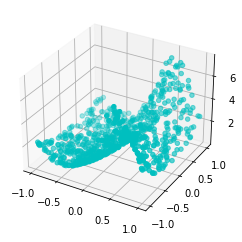

In [209]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dataset['train_input'][:, 0], dataset['train_input'][:, 1], dataset['train_label'], c='c', marker='o')
plt.show()

-   $2$
    -   $x_1, x_2$
-   $5$
    -   $2x+1 = 5$
-   $1$
    -   $2-1$

In [210]:
model = KAN(width=[2,5,1], grid=3, k=3, seed=0)

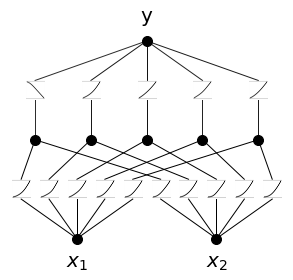

In [211]:
model(dataset['train_input'])
model.plot(beta=100, in_vars=['$x_1$', '$x_2$'], out_vars=['y']) # beta controls the transparency of the plot

In [212]:
res = model.train(dataset, opt="LBFGS", steps=20, lamb=0.01, lamb_entropy=10.)

train loss: 1.09e-01 | test loss: 9.79e-02 | reg: 2.11e+01 : 100%|██| 20/20 [00:04<00:00,  4.61it/s]

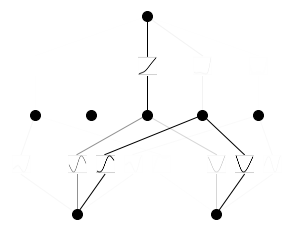

In [213]:
model.plot()

**가지치기**

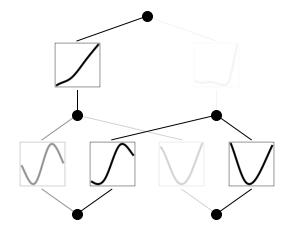

In [214]:
model2 = model.prune()
model2(dataset['train_input'])
model2.plot()

In [215]:
model2.suggest_symbolic(0,0,0) 

function , r2
sin , 0.9966473579406738
gaussian , 0.9244089722633362
tanh , 0.8837200999259949
sigmoid , 0.8783647418022156
arctan , 0.8637073636054993

## Classification

## iris data

In [237]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder() 

# Iris dataset
iris = load_iris()
X = torch.tensor(iris.data, dtype=torch.float32)
y = enc.fit_transform(iris.target.reshape(-1, 1)).toarray()
y = torch.tensor(y, dtype=torch.float32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
dataset = dict(train_input=X_train, train_label=y_train, test_input=X_test, test_label=y_test)

$4 \times 2 + 1 =9$

In [240]:
X.shape, y.shape

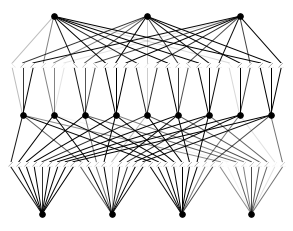

In [144]:
# Create KAN
model = KAN(width=[4,9,3], grid=3, k=3, seed=0)
model(X_train)
model.plot()

train loss: 2.88e-01 | test loss: 2.52e-01 | reg: 6.61e+01 : 100%|██| 20/20 [00:08<00:00,  2.35it/s]

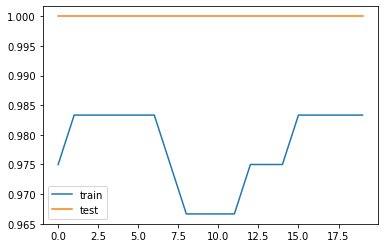

In [145]:
# Train KAN
from sklearn.metrics import accuracy_score

def train_acc():
    return torch.mean((torch.argmax(model(dataset['train_input']), dim=1) == torch.argmax(dataset['train_label'], dim=1)).float())

def test_acc():
    return torch.mean((torch.argmax(model(dataset['test_input']), dim=1) == torch.argmax(dataset['test_label'], dim=1)).float())

res = model.train(dataset, opt="LBFGS", metrics=[train_acc, test_acc], steps=20, lamb=0.01, lamb_entropy=10., loss_fn=torch.nn.CrossEntropyLoss())

# Accuracy plot
fig, ax = plt.subplots()
ax.plot(res["train_acc"], label="train")
ax.plot(res["test_acc"], label="test")
ax.legend()
plt.show()

## ECG

-   abnormal = 0, normal = 1
-   ~139 열까지는 시간에 따른 심전도

In [77]:
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
# dataframe.head()

Normalize the data

In [78]:
def normalize(df):
    return (df - df.min()) / (df.max() - df.min())

In [79]:
raw_dat = np.array(normalize(raw_data[:, 0:-1]))

In [114]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder() 

X = torch.tensor(raw_dat[:, :], dtype=torch.float32)
y = enc.fit_transform(raw_data[:, -1].reshape(-1, 1)).toarray()
y = torch.tensor(y, dtype=torch.float32)

In [156]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4) 

In [157]:
X1 = torch.tensor(pca.fit_transform(X))

In [158]:
X1.shape, y.shape

In [159]:
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.3, random_state=0)
dataset = dict(train_input=X_train, train_label=y_train, test_input=X_test, test_label=y_test)

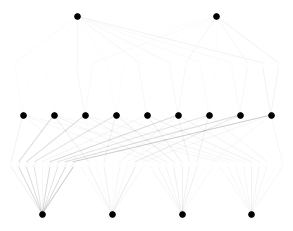

In [160]:
model = KAN(width=[4,9,2], grid=3, k=3, seed=0)
model(X_train)
model.plot()

train loss: 2.69e-01 | test loss: 2.88e-01 | reg: 2.94e+01 : 100%|██| 20/20 [00:19<00:00,  1.05it/s]

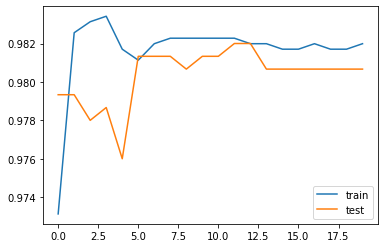

In [161]:
from sklearn.metrics import accuracy_score

def train_acc():
    return torch.mean((torch.argmax(model(dataset['train_input']), dim=1) == torch.argmax(dataset['train_label'], dim=1)).float())

def test_acc():
    return torch.mean((torch.argmax(model(dataset['test_input']), dim=1) == torch.argmax(dataset['test_label'], dim=1)).float())

res = model.train(dataset, opt="LBFGS", metrics=[train_acc, test_acc], steps=20, lamb=0.01, lamb_entropy=10., loss_fn=torch.nn.CrossEntropyLoss())

# Accuracy plot
fig, ax = plt.subplots()
ax.plot(res["train_acc"], label="train")
ax.plot(res["test_acc"], label="test")
ax.legend()
plt.show()

In [227]:
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
# dataframe.head()

Normalize the data

In [228]:
def normalize(df):
    return (df - df.min()) / (df.max() - df.min())

In [229]:
raw_dat = np.array(normalize(raw_data[:, 0:-1]))

In [230]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder() 

X = torch.tensor(raw_dat[:, :], dtype=torch.float32)
y = enc.fit_transform(raw_data[:, -1].reshape(-1, 1)).toarray()
y = torch.tensor(y, dtype=torch.float32)

In [231]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4) 

In [232]:
X1 = torch.tensor(pca.fit_transform(X))

In [233]:
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.3, random_state=0)
dataset = dict(train_input=X_train, train_label=y_train, test_input=X_test, test_label=y_test)

In [234]:
model = KAN(width=[4,9,2], grid=3, k=3, seed=0)

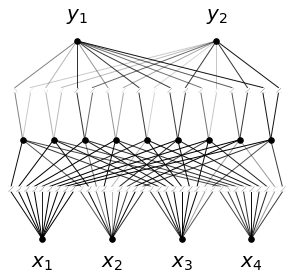

In [235]:
model(dataset['train_input'])
model.plot(beta=100, in_vars=['$x_1$', '$x_2$', '$x_3$', '$x_4$'], out_vars=['$y_1$','$y_2$']) # beta controls the transparency of the plot

In [236]:
res = model.train(dataset, opt="LBFGS", steps=20, lamb=0.01, lamb_entropy=10.)

train loss: 2.06e-01 | test loss: 2.10e-01 | reg: 3.68e+01 : 100%|██| 20/20 [00:17<00:00,  1.13it/s]

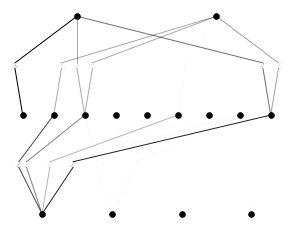

In [237]:
model.plot()

**가지치기**

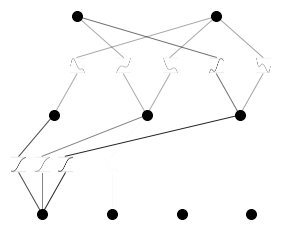

In [238]:
model2 = model.prune()
model2(dataset['train_input'])
model2.plot()

In [239]:
model2.suggest_symbolic(0,0,0) 

function , r2
sigmoid , 0.9998123908724215
tanh , 0.9998079275604033
sin , 0.9996524257432485
arctan , 0.9995603813134804
gaussian , 0.9994074762181313

In [240]:
from scipy.misc import electrocardiogram
ecg = electrocardiogram()
ecg

  ecg = electrocardiogram()

In [242]:
lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','tan','abs']
model.auto_symbolic(lib=lib)
formula = model.symbolic_formula()[0][0]

skipping (0,0,0) since already symbolic
skipping (0,0,1) since already symbolic
skipping (0,0,2) since already symbolic
skipping (0,0,3) since already symbolic
skipping (0,0,4) since already symbolic
skipping (0,0,5) since already symbolic
skipping (0,0,6) since already symbolic
skipping (0,0,7) since already symbolic
skipping (0,0,8) since already symbolic
skipping (0,1,0) since already symbolic
skipping (0,1,1) since already symbolic
skipping (0,1,2) since already symbolic
skipping (0,1,3) since already symbolic
skipping (0,1,4) since already symbolic
skipping (0,1,5) since already symbolic
skipping (0,1,6) since already symbolic
skipping (0,1,7) since already symbolic
skipping (0,1,8) since already symbolic
skipping (0,2,0) since already symbolic
skipping (0,2,1) since already symbolic
skipping (0,2,2) since already symbolic
skipping (0,2,3) since already symbolic
skipping (0,2,4) since already symbolic
skipping (0,2,5) since already symbolic
skipping (0,2,6) since already symbolic


https://docs.scipy.org/doc/scipy/reference/generated/scipy.misc.electrocardiogram.html

In [281]:
from scipy.misc import electrocardiogram
ecg = electrocardiogram()
fs = 360
time = (torch.tensor(np.arange(ecg.size) / fs)).reshape(-1,1)
ecg = torch.tensor(ecg.reshape(-1,1))

  ecg = electrocardiogram()

In [282]:
X_train, X_test, y_train, y_test = train_test_split(time, ecg, test_size=0.3, random_state=0)
dataset = dict(train_input=X_train, train_label=y_train, test_input=X_test, test_label=y_test)

In [283]:
model = KAN(width=[1,2], grid=200, k=3, noise_scale=0.1, sp_trainable=False, sb_trainable=False)

In [284]:
model.train(dataset, opt="LBFGS", steps=20, lamb=0.01, lamb_entropy=10.)

train loss: 4.09e-01 | test loss: 4.07e-01 | reg: 1.08e+01 : 100%|██| 20/20 [02:27<00:00,  7.39s/it]

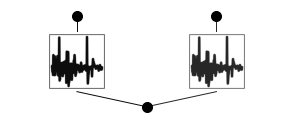

In [285]:
model.plot()

In [286]:
lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','tan','abs']
model.auto_symbolic(lib=lib)
formula = model.symbolic_formula()[0][0]

fixing (0,0,0) with sin, r2=0.057382220367117785
fixing (0,0,1) with sin, r2=0.057381458884463804